# Surprise SVD
To benchmark our manual SVD implementation, we'll train the SVD model from `surprise` on the same data.

## Init

In [1]:
%%capture
import sys
import os

# Add project root to Python path
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)
# import packages
from utils.imports import *
# import user-defined funcs and classes
from utils.helpers import plot_heatmap
from utils.helpers import get_top_n
from utils.helpers import top_n_coverage
from utils.helpers import round_half

In [2]:
# import pandas dataframes
with open("../data/dataframes.pkl", "rb") as f:
    data = pickle.load(f)

train = data["train"]
validation = data["validation"]
baseline = data["baseline"]

# load sparse matrix
ui_csr = load_npz("../data/ui_csr.npz")

# load encodings
with open("../artifacts/user_encoder.pkl", "rb") as f:
    user_encoder = pickle.load(f)
with open("../artifacts/item_encoder.pkl", "rb") as f:
    item_encoder = pickle.load(f)
with open("../artifacts/user_map.pkl", "rb") as f:
    user_map = pickle.load(f)
with open("../artifacts/item_map.pkl", "rb") as f:
    item_map = pickle.load(f)

In [3]:
# import surprise tools
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, GridSearchCV

In [4]:
# create reader
reader = Reader(rating_scale=(0, 5))
# generate surprise data
train_ds = Dataset.load_from_df(
    train[['user_idx', "item_idx", "review_overall"]], reader)
# create set for training surprise model
trainset = train_ds.build_full_trainset()
# format validation set for testing
valset = list(zip(validation['user_idx'],
                  validation['item_idx'],
                  validation['review_overall']))

## Grid Search
We'll perform a grid search over the same grid of hyperparameters we searched in the manual SVD implementation.

In [5]:
# set parameter grid
k_grid = np.array([25,50,75,100]) # set k grid
reg_grid = np.array([0.001, 0.02, 0.1]) # set reg grid
grid = itertools.product(k_grid, reg_grid)
surprise_models = []
# dataframe for grid search
surprise_grid_search = pd.DataFrame(columns=('reg', 'k', 'RMSE', 'MAE', 'coverage'))
for k, reg in grid:
    # fit model with grid params
    model = SVD(n_factors=k, reg_all=reg)
    model.fit(trainset)
    # test on validation set
    preds = model.test(valset)
    # we need to calculate RMSE and MAE on the rounded predictions
    rounded_preds = []
    for pred in preds:
        est = min(max(pred.est, model.trainset.rating_scale[0]), model.trainset.rating_scale[1])  # clip
        est_rounded = round_half(est)
        # create a new Prediction object with rounded value
        rounded_preds.append(pred._replace(est=est_rounded))
    # compute accuracy metrics on rounded predictions
    rmse = accuracy.rmse(rounded_preds, verbose=False)
    mae = accuracy.mae(rounded_preds,verbose=False)
    # evaluate coverage
    N = 10
    coverage = top_n_coverage(model, trainset, N) # get training set item catalog coverage @ top 10 beers
    # add results to dataframe
    surprise_grid_search.loc[len(surprise_grid_search)]= (reg, k, rmse, mae, coverage)
    # save model
    surprise_models.append(model)

In [6]:
surprise_grid_search

,reg,k,RMSE,MAE,coverage
0,0.001,25.0,0.708938,0.502835,0.129601
1,0.020,25.0,0.707363,0.501072,0.427035
2,0.100,25.0,0.706581,0.501348,0.430416
3,0.001,50.0,0.711542,0.505186,0.218666
4,0.020,50.0,0.707864,0.502213,0.653193
5,0.100,50.0,0.708169,0.502731,0.579574
6,0.001,75.0,0.714246,0.507572,0.287712
7,0.020,75.0,0.710691,0.504979,0.744409
8,0.100,75.0,0.706520,0.501314,0.631522
9,0.001,100.0,0.718866,0.511755,0.354837


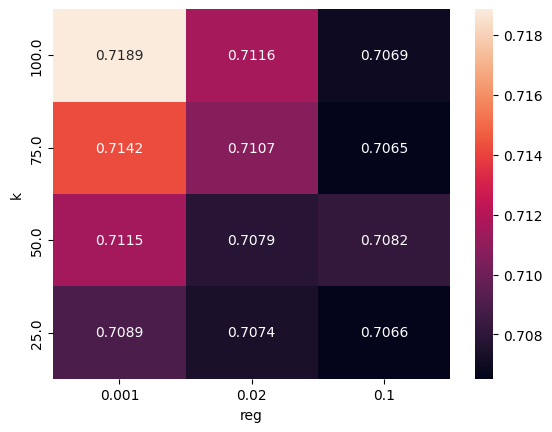

In [7]:
plot_heatmap(surprise_grid_search, 'RMSE')

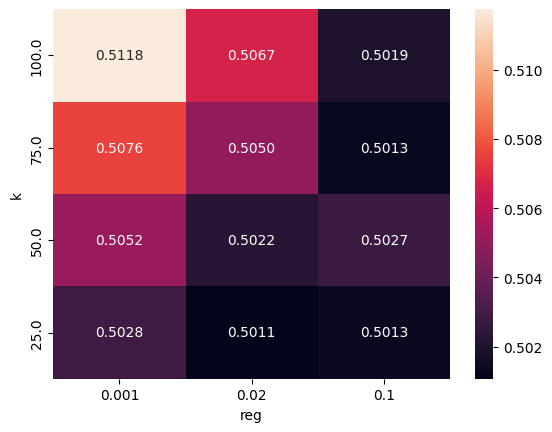

In [8]:
plot_heatmap(surprise_grid_search, 'MAE')

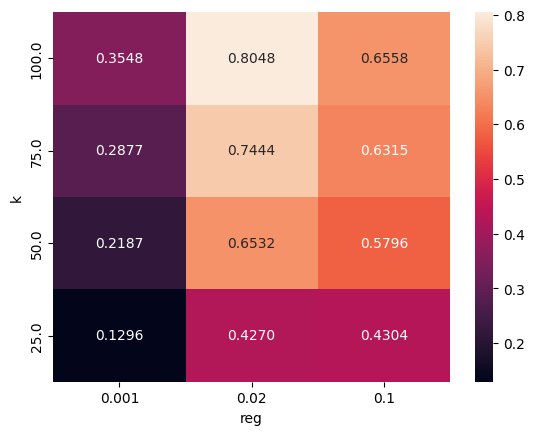

In [9]:
plot_heatmap(surprise_grid_search, 'coverage')